# Capstone Project - Visualisation

Objective: Using the given dataset, produce the following insights:
 - 1, The best performing product
 - 2, Information on user demographics
 - 3, Whether sales are seasonal
 - 4, Justification of marketing spends in the regions UK South East, UK North East, UK North, and UK South
 - 5, CPA (cost per acquisition) per region against the expected average (available at https://mystaticwebsite-3.s3.amazonaws.com/index.html)

Created By: Solomon Williams

Creation Date: 04/11/2022

##### Last Updated

In [36]:
from datetime import datetime, timedelta

print(f"Last Updated: {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")

Last Updated: 08/11/2022 15:30:55


### Importing Packages

In [37]:
import pandas as pd
import numpy as np

# Packages for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for web scraping
import requests
from bs4 import BeautifulSoup
import re

### Importing Clean Data

In [38]:
df = pd.read_csv('clean_capstone_data.csv')

# Again, I want to display the float values as integers without changing their format:
pd.options.display.float_format = '{:,.0f}'.format

df.head()

,order_id,product,quantity,age,uk_region,cpa,month,year
0,1,toothbrush,1,21,UK North East,2,Oct,2021
1,2,toys,2,35,UK South East,3,Oct,2021
2,3,toothbrush,1,24,UK North,2,Oct,2021
3,4,toothbrush,1,21,UK North East,4,Dec,2021
4,5,toothbrush,2,20,UK North,5,Oct,2021


### Objective 1: Product Performances

I will produce a bar chart comparing the total number of sales for each product. This will involve creating a new table of the sum of quantities sold for each product.

In [39]:
sales = df.groupby(['product']).quantity.sum().reset_index()

# As this data will be plotted, I want to capitalize the entries:
sales['product'] = sales['product'].str.capitalize()

sales.head()

,product,quantity
0,Toothbrush,39
1,Toys,27


Alternatively, this could have been done by creating a view in the MySQL database:<br>

CREATE VIEW sales AS <br>
SELECT <br>
CAP.product, <br>
SUM(CAP.quantity) <br>
FROM clean_capstone_data CAP <br>
GROUP BY product; <br>
<br>
and then reading the exported CSV into Python.

Now I will plot the information:

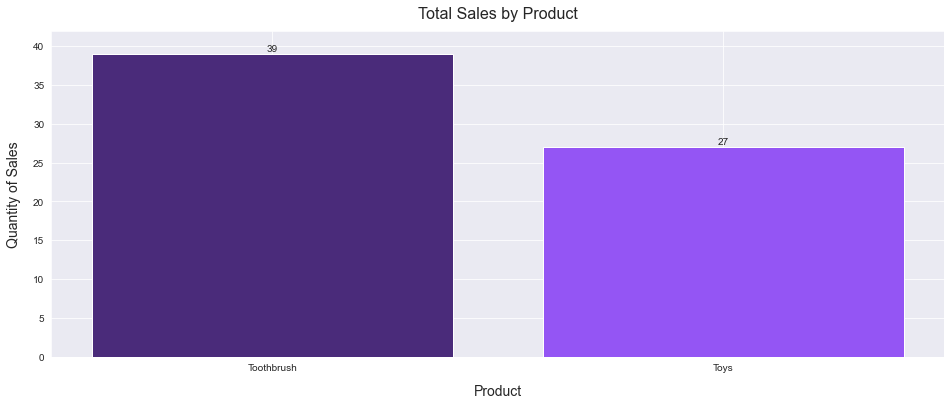

In [40]:
fig, ax = plt.subplots(1, 1, figsize = (16,6))
sns.set_style("darkgrid")

plt.bar(x=sales['product'], height = sales['quantity'].astype(int), color = ['#4a2b7a', '#9455f4'], width = 0.8, align = 'center')

ax.set_xlabel('Product', fontdict={'fontsize':14}, labelpad=12)
ax.set_ylabel('Quantity of Sales', fontdict={'fontsize':14}, labelpad=12)
ax.set_title('Total Sales by Product', fontdict={'fontsize':16}, pad=12)

# The following code will add counter labels to each bar for easier visualisation:
for rect1 in ax.containers[0]:
    height = rect1.get_height()
    plt.annotate("{}".format(height),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom")

# This adds a bit of space at the top of my chart for the bar labels:
plt.ylim(0,42)

plt.savefig('Product_Sales.png', bbox_inches='tight', dpi=150, facecolor=(1,1,1))
plt.show()

In [41]:
print(f'Toothbrush sales make up {round(39*100/(39+27), 1)}% of total sales')

Toothbrush sales make up 59.1% of total sales


#### Conclusion
From this plot it's clear to see that toothbrushes are performing better than toys, serving as roughly 60% of all purchases.

### Objective 2: Demographic Information

I will create two pie charts to convey customer demographics for anyone who made a purchse, regardless of the quantity of products bought.<br> The first chart will be based on age, grouped by the ranges: Under 25, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, Over 55.<br>

The second chart will be based on region.

I will generate a MySQL view for age ranges using the following query:<br>

CREATE VIEW age_range AS <br>
SELECT <br>
CASE <br>
WHEN age < 25 THEN 'Under 25' <br>
WHEN age BETWEEN 25 AND 29 THEN '25-29' <br>
WHEN age BETWEEN 30 AND 34 THEN '30-34' <br>
WHEN age BETWEEN 35 AND 39 THEN '35-39' <br>
WHEN age BETWEEN 40 AND 44 THEN '40-44' <br>
WHEN age BETWEEN 45 AND 49 THEN '45-49' <br>
WHEN age BETWEEN 50 AND 54 THEN '50-54' <br>
WHEN age >= 55 THEN 'Over 55' <br>
END AS age_range <br>
FROM clean_capstone_data <br>
<br>
This is exported as 'age_range.csv'

In [42]:
age_range = pd.read_csv('age_range.csv')
age_range.head()

,age_range
0,Under 25
1,35-39
2,Under 25
3,Under 25
4,Under 25


In [43]:
print(age_range.value_counts())
print(df['uk_region'].value_counts())

age_range
Under 25     21
Over 55      10
30-34         9
35-39         6
50-54         3
45-49         1
dtype: int64
UK South East    22
UK North East    20
UK North          8
Name: uk_region, dtype: int64


There are no entries for ages 25-29 and 40-44, so we can omit these in our pie chart labels. Similarly, the label for UK South will be omitted in the region chart. <br>
These labels are written in order of highest to lowest count.

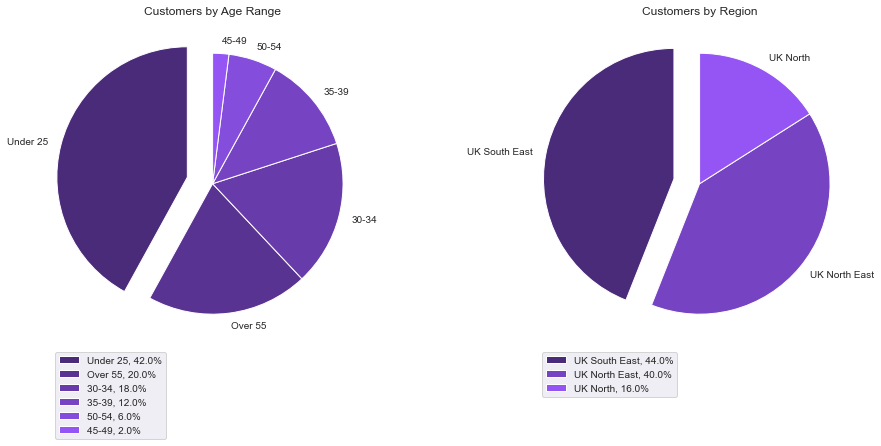

In [44]:
fig, ax = plt.subplots(1, 2, figsize = (16,6))

age_labels = ['Under 25', 'Over 55', '30-34', '35-39', '50-54', '45-49']
region_labels = ['UK South East', 'UK North East', 'UK North']
colors = ['#4a2b7a', '#593392', '#683bab', '#7644c3', '#854ddc', '#9455f4']

ax[0].set_title('Customers by Age Range')
ax[0].pie(age_range.value_counts(), labels = age_labels, colors=colors[:6],  startangle = 90, 
        explode = [0.2, 0, 0, 0, 0, 0])

ax[1].set_title('Customers by Region')
ax[1].pie(df['uk_region'].value_counts(), labels = region_labels, colors=[colors[0],colors[3], colors[5]],  startangle = 90, 
        explode = [0.2, 0, 0])

# The following code will add a legend to each chart indicating the percentages,
# hence the use of (count/len(df))*100 to return each count as a percentage of
# the total number of rows in the dataframe.

labels = [f'{value}, {(count/len(df))*100:0.1f}%' for value, count in zip(age_labels, age_range.value_counts())]
ax[0].legend(bbox_to_anchor=(0, 0), loc='upper left', labels=labels)

labels = [f'{value}, {(count/len(df)*100):0.1f}%' for value, count in zip(region_labels, df['uk_region'].value_counts())]
ax[1].legend(bbox_to_anchor=(0, 0), loc='upper left', labels=labels)

plt.savefig('Demographics.png', bbox_inches='tight', dpi=150, facecolor=(1,1,1))
plt.show()

#### Conclusion
The first of these visuals shows that the most popular age demographic is people under 25, followed by those over 55 and then between 30-34. Conversely, the least popular age demographics are ages 25-29 and 40-44, for which there were no recorded sales, and people aged 45-54, who comprised only 8% of customers.

The second visual shows that the North East and South East are by far the most popular customer regions. Conversely, UK North represents around just 16% of customers, and the South recorded none whatsoever.

Marketing may want to either focus on their best-performing demographics, or help boost the under-performing ones. Either way, these visuals should help them draw the conclusions they need and allocate resources, as necessary.

### Objective 3: Sales Throughout the Year

For this objective, I will plot the number of sales against the month to determine which months perform best and whether or not the sales seem seasonal.

Firstly, I will create the following view in MySQL:

CREATE VIEW month_sales AS <br>
SELECT <br>
SUM(CAP.quantity) Sales, <br>
CAP.month Month <br>
FROM clean_capstone_data CAP <br>
GROUP BY CAP.month <br>
<br>
This view is exported as 'month_sales.csv'

In [45]:
month_sales = pd.read_csv('month_sales.csv')
month_sales.head()

,Month,Sales
0,Dec,11
1,Jan,18
2,Mar,19
3,May,2
4,Oct,16


I want to order this so that January is the first month. This can be done using pd.concat().

In [46]:
month_sales = pd.concat([month_sales[1:], month_sales[0:1]])
month_sales.head()

,Month,Sales
1,Jan,18
2,Mar,19
3,May,2
4,Oct,16
0,Dec,11


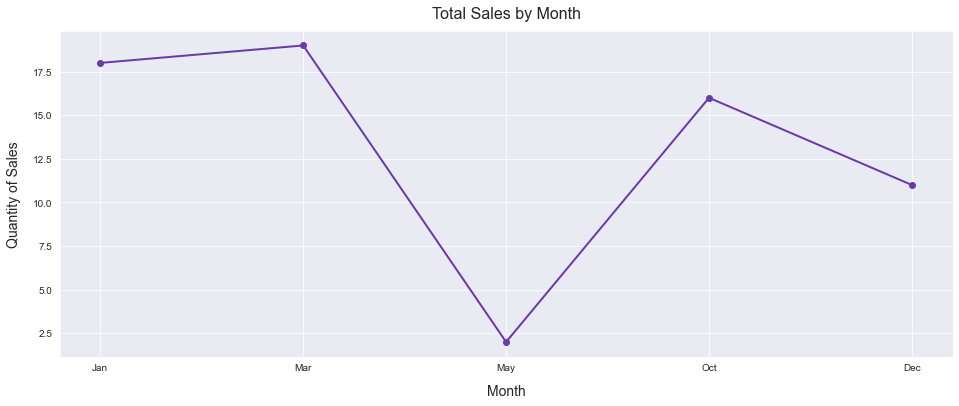

In [47]:
fig, ax = plt.subplots(1, 1, figsize = (16,6))

X = month_sales['Month']
y = month_sales['Sales']

ax.plot(X, y, color = '#683bab', marker = 'o', linewidth = 2)

ax.set_xlabel('Month', fontdict={'fontsize':14}, labelpad=12)
ax.set_ylabel('Quantity of Sales', fontdict={'fontsize':14}, labelpad=12)
ax.set_title('Total Sales by Month', fontdict={'fontsize':16}, pad=12)

plt.savefig('Month_Sales.png', bbox_inches='tight', dpi=150, facecolor=(1,1,1))
plt.show()

#### Conclusion
It's clear that sales perform considerably worse around May than at any other time of year. This is an indication that sales are indeed seasonal, drastically underperforming in the summer months. Conversely, they perform best between January and March, with the peak number of sales occurring in the spring. After summer, the sales increase again during autumn, but then there is another clear downward trend as winter begins. We could expect to see that the sales would pick up again in the new year, completing the cycle.

### Objective 4: Performance by Region

I will use the following view created in MySQL:

CREATE VIEW regions AS <br>
SELECT <br>
SUM(CAP.quantity) Sales, <br>
CAP.uk_region Region <br>
FROM clean_capstone_data CAP <br>
GROUP BY CAP.uk_region <br>
<br>
This view is exported as 'regions.csv' <br>
The number of sales will be read as an integer<br>

In [48]:
regions = pd.read_csv('regions.csv')
regions['Sales'] = regions['Sales'].astype(int)
regions.head()

,Sales,Region
0,10,UK North
1,20,UK North East
2,36,UK South East


I will also use this view for objective 4:

CREATE VIEW region_sales AS <br>
SELECT <br>
CAP.product, <br>
CAP.uk_region, <br>
SUM(CAP.quantity) sold <br>
FROM clean_capstone_data CAP <br>
GROUP BY CAP.product, CAP.uk_region <br>
<br>
This view is exported as 'region_sales.csv'

In [49]:
region_sales = pd.read_csv('region_sales.csv')
region_sales['sold'] = region_sales['sold'].astype(int)

# Cleaning up data for plotting purposes
region_sales['Product'] = region_sales['product'].str.capitalize()
del region_sales['product']
region_sales.head()

,uk_region,sold,Product
0,UK North,10,Toothbrush
1,UK North East,20,Toothbrush
2,UK South East,9,Toothbrush
3,UK South East,27,Toys


I will convert this into a plottable DataFrame:

In [50]:
plotdata = region_sales.pivot_table('sold', ['uk_region'], 'Product')
plotdata = plotdata.fillna(0)

plotdata.head()

Product,Toothbrush,Toys
uk_region,,
UK North,10,0
UK North East,20,0
UK South East,9,27


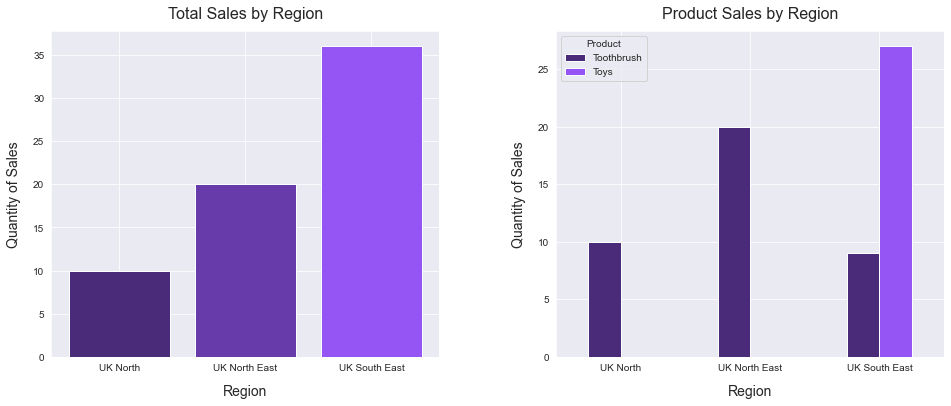

In [51]:
fig, ax = plt.subplots(1,2, figsize = (16,6))

X = regions['Region']
y = regions['Sales']

ax[0].bar(x=X, height=y, color = ['#4a2b7a', '#683bab','#9455f4'])

ax[0].set_xlabel('Region', fontdict={'fontsize':14}, labelpad=12)
ax[0].set_ylabel('Quantity of Sales', fontdict={'fontsize':14}, labelpad=12)
ax[0].set_title('Total Sales by Region', fontdict={'fontsize':16}, pad=12)

plotdata.plot(kind='bar', ax=ax[1], color = ['#4a2b7a', '#9455f4'], rot=0)

ax[1].set_xlabel('Region', fontdict={'fontsize':14}, labelpad=12)
ax[1].set_ylabel('Quantity of Sales', fontdict={'fontsize':14}, labelpad=12)
ax[1].set_title('Product Sales by Region', fontdict={'fontsize':16}, pad=12)
    
plt.subplots_adjust(wspace = 0.3) 
plt.savefig('Region_Sales.png', bbox_inches='tight', dpi=150, facecolor=(1,1,1))
plt.show()

In [52]:
print(f'UK North recorded {round(10*100/66, 1)}% of total sales')
print(f'UK North East recorded {round(20*100/66, 1)}% of total sales')
print(f'UK South East recorded {round(36*100/66, 1)}% of total sales')

UK North recorded 15.2% of total sales
UK North East recorded 30.3% of total sales
UK South East recorded 54.5% of total sales


#### Conclusion
Firstly, marketing in the UK South region has proven to be wasteful expenditure, as there have been no recorded sales. Undoubtedly, the expenditure can be justified in the South East as they have recorded 54.5% of all sales with just 44% of total customers. The North East represents 40% of customers, yet they only made up 30.3% of total sales, suggesting that people in this region purchase products in lower quantities. Finally, while, on the face of it, it seems that the North is lacking, with 15.2% of total sales from just 16% of customers, this region is actually performing fairly well.

Outside of the South East, there were no recorded toys sales. If the marketing team have been advertising toys outside of this region, it's safe to say that this was wasteful expenditure. Moreover, despite this high volume of toy sales, the toothbrush sales in the South East were fairly low, comparable to those in the North (despite a large difference in customer numbers), and the majority being sold in the North East. This could still be indicative of wasteful expenditure if the allocation of marketing spend was uniform across all regions, as we'd hope to see an equal split in customer numbers and sales across each region if that were the case.

### Objective 5: CPAs Per Region

In order to compare the CPA per region against the regional average, I will need to scrape that information from the given URL. It is worth noting that this information seems to only be relevant for purchases made in October 2021.

Firstly, I will use the requests and BeautifulSoup packages to retrieve the page content for the URL.

In [53]:
URL = 'https://mystaticwebsite-3.s3.amazonaws.com/index.html'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')

print(soup.prettify)

<bound method Tag.prettify of <html>
<head>
</head>
<body>
<h1>Marketing Data October 2021</h1>
<table style="width: 100%">
<tr style="font-weight: bold">
<th style="width: 50%">Region
<th style="">Average CPA by Region
</th></th></tr>
<tr>
<td class="region">South East</td>
<td id="south_east">£10.00</td>
</tr>
<tr>
<td class="region">North East</td>
<td id="north_east">£10.00</td>
</tr>
<tr>
<td class="region">North</td>
<td id="north">£8.00</td>
</tr>
<tr>
<td class="region">South</td>
<td id="south">£10.00</td>
</tr>
</table>
</body>
</html>
>


I will now narrow down my search based on the elements of the page that are holding the data I wish to obtain.

In [54]:
results = soup.find('table')
print(results.prettify)

<bound method Tag.prettify of <table style="width: 100%">
<tr style="font-weight: bold">
<th style="width: 50%">Region
<th style="">Average CPA by Region
</th></th></tr>
<tr>
<td class="region">South East</td>
<td id="south_east">£10.00</td>
</tr>
<tr>
<td class="region">North East</td>
<td id="north_east">£10.00</td>
</tr>
<tr>
<td class="region">North</td>
<td id="north">£8.00</td>
</tr>
<tr>
<td class="region">South</td>
<td id="south">£10.00</td>
</tr>
</table>>


Finally, I will collect this data into two lists, one for the region and one for the expected average CPA. I will zip this into a dictionary.

In [55]:
cpa_elements = results.find_all('tr')

regions = []

# This is my regular expression for finding a price in the format 
# £__.xx, returning a list of all prices in order of appearance on the page
# I then make this a float value without the £ symbol
re_cpas = '([£]\d+\.\d{2})'
cpas = (re.findall(re_cpas, str(cpa_elements)))
cpas =  [float(x.replace('£', '')) for x in cpas]

for cpa_element in cpa_elements:
    region_element = cpa_element.find(class_='region')
    try:
        regions.append('UK ' + region_element.text.strip())
    except:
        pass
        # I included this exception to avoid NoneType errors

expected_cpas = dict(zip(regions, cpas))
print(expected_cpas)

{'UK South East': 10.0, 'UK North East': 10.0, 'UK North': 8.0, 'UK South': 10.0}


I will sort this dictionary into alphabetical order:

In [56]:
sorted_cpas = {key: value for key, value in sorted(expected_cpas.items())}

print(sorted_cpas)

{'UK North': 8.0, 'UK North East': 10.0, 'UK South': 10.0, 'UK South East': 10.0}


I will now compare these values to my cleaned data, specifically against all entries for October 2021. This was found using the following MySQL query:

CREATE VIEW CPAs AS <br>
SELECT <br>
CAP.uk_region Region, <br>
AVG(CAP.cpa) Avg_CPA <br>
FROM clean_capstone_data CAP <br>
WHERE month = 'Oct' and year = '2021' <br>
GROUP BY CAP.uk_region <br>

This view is exported as 'CPAs.csv' and float values will be rounded to 2 decimal places <br>
I will also add in an empty 'UK South' row.

In [57]:
CPAs = pd.read_csv('CPAs.csv', index_col=False)
pd.options.display.float_format = '{:,.2f}'.format

# Adding an empty row for UK South data
new_row = pd.Series(data={'Region':'UK South', 'Avg_CPA': 0})
new_df = pd.DataFrame([new_row])
CPAs = pd.concat([CPAs, new_df], axis=0, ignore_index=True)

# Tidying up the column name for my plot
CPAs['Actual CPA Average'] = CPAs['Avg_CPA']
del CPAs['Avg_CPA']

CPAs.head()

,Region,Actual CPA Average
0,UK North,4.67
1,UK North East,2.50
2,UK South East,3.71
3,UK South,0.00


Again, I want to sort this alphabetically:

In [58]:
CPAs.sort_values('Region')
CPAs.head()

,Region,Actual CPA Average
0,UK North,4.67
1,UK North East,2.50
2,UK South East,3.71
3,UK South,0.00


Finally, I want to add a column of expected CPA values using my web scraping results:

In [59]:
cpas = []

for key, value in sorted_cpas.items():
    cpas.append(value)

CPAs['Expected CPA Average'] = cpas

CPAs.head()

,Region,Actual CPA Average,Expected CPA Average
0,UK North,4.67,8.00
1,UK North East,2.50,10.00
2,UK South East,3.71,10.00
3,UK South,0.00,10.00


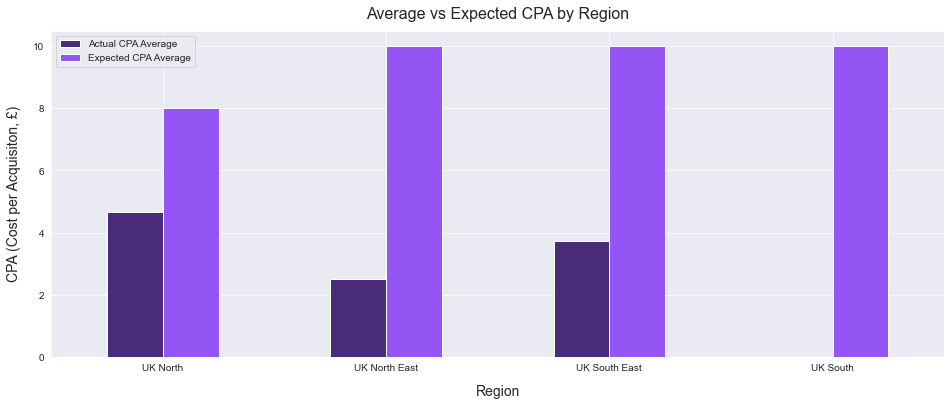

In [60]:
fig, ax = plt.subplots(1,1, figsize = (16,6))


CPAs.plot(x = 'Region', kind='bar', ax=ax,color = ['#4a2b7a', '#9455f4'], rot=0)

ax.set_xlabel('Region', fontdict={'fontsize':14}, labelpad=12)
ax.set_ylabel('CPA (Cost per Acquisiton, £)', fontdict={'fontsize':14}, labelpad=12)
ax.set_title('Average vs Expected CPA by Region', fontdict={'fontsize':16}, pad=12)


plt.savefig('Region_CPAs.png', bbox_inches='tight', dpi=150, facecolor=(1,1,1))
plt.show()

#### Conclusion
For all three regions where we had data, it was evident that the actual CPA was significantly below the expected value. Surprisingly, UK north had the highest actual CPA despite having a lower expected CPA than the others. Nonetheless, this is a positive finding, and shows that the current marketing strategies are acquiring customers at a lower cost than anticipated.